# Time Series

# Forecasting Stock Price 

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
sbi_df = pd.read_csv('SBI_Historical_Data.csv')

## Q. 1 EDA

### a. Print dimensions of the data

In [3]:
print("Dimensions of the data:", sbi_df.shape)

Dimensions of the data: (1385, 7)


### b. Dimensions of Dataset

In [4]:
print("Dimensions of Dataset:")
sbi_df.head()

Dimensions of Dataset:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 07, 2020",190.65,191.45,192.10,189.55,44.82M,-0.16%
1,"Aug 06, 2020",190.95,192.30,194.50,190.25,59.74M,-0.26%
2,"Aug 05, 2020",191.45,192.75,196.85,191.00,68.89M,-0.08%
3,"Aug 04, 2020",191.60,193.35,193.80,190.50,43.87M,-0.34%
4,"Aug 03, 2020",192.25,192.00,194.60,190.05,72.46M,0.42%


### c. Statistical Summary

In [5]:
print("Statistical Summary:")
sbi_df.describe()

Statistical Summary:


,Price,Open,High,Low
count,1385.000000,1385.000000,1385.000000,1385.000000
mean,266.274404,266.903213,270.343682,262.757906
std,45.555277,45.590664,45.829745,45.248334
min,150.850000,151.950000,153.200000,148.250000
25%,245.650000,245.900000,248.800000,242.550000
50%,270.800000,271.150000,274.600000,267.400000
75%,296.150000,296.500000,300.750000,292.200000
max,372.400000,371.950000,373.800000,366.200000


### d. Converting Date

In [6]:
sbi_df['Date'] = pd.to_datetime(sbi_df['Date'])

### e. Check Data Type and Missing Values

In [7]:
print("Data Types and Missing Values:")
sbi_df.info()

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1385 non-null   datetime64[ns]
 1   Price     1385 non-null   float64       
 2   Open      1385 non-null   float64       
 3   High      1385 non-null   float64       
 4   Low       1385 non-null   float64       
 5   Vol.      1385 non-null   object        
 6   Change %  1385 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 75.9+ KB


### f. Index the dataset with Date

In [8]:
sbi_df.set_index('Date', inplace=True)


In [9]:
sbi_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-08-07,190.65,191.45,192.10,189.55,44.82M,-0.16%
2020-08-06,190.95,192.30,194.50,190.25,59.74M,-0.26%
2020-08-05,191.45,192.75,196.85,191.00,68.89M,-0.08%
2020-08-04,191.60,193.35,193.80,190.50,43.87M,-0.34%
2020-08-03,192.25,192.00,194.60,190.05,72.46M,0.42%


## Q. 2 Time Series Analysis

### a. Visualize time series data

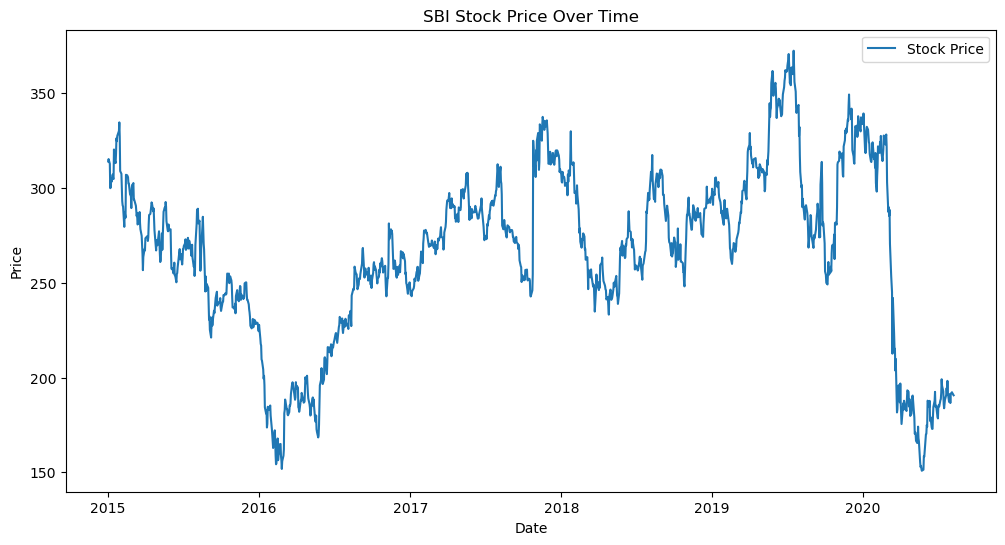

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(sbi_df['Price'], label='Stock Price')
plt.title('SBI Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### b. Check Stationarity with ADF Test

In [11]:
adf_result = adfuller(sbi_df['Price'])
print("ADF Test p-value:", adf_result[1])

ADF Test p-value: 0.07689543355657329


### Check Stationarity with KPSS Test

In [12]:
kpss_result = kpss(sbi_df['Price'])
print("KPSS Test p-value:", kpss_result[1])

KPSS Test p-value: 0.01


### c. Perform decomposing

In [13]:
decomposition = seasonal_decompose(sbi_df['Price'], model='additive', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#### Plot decomposed components

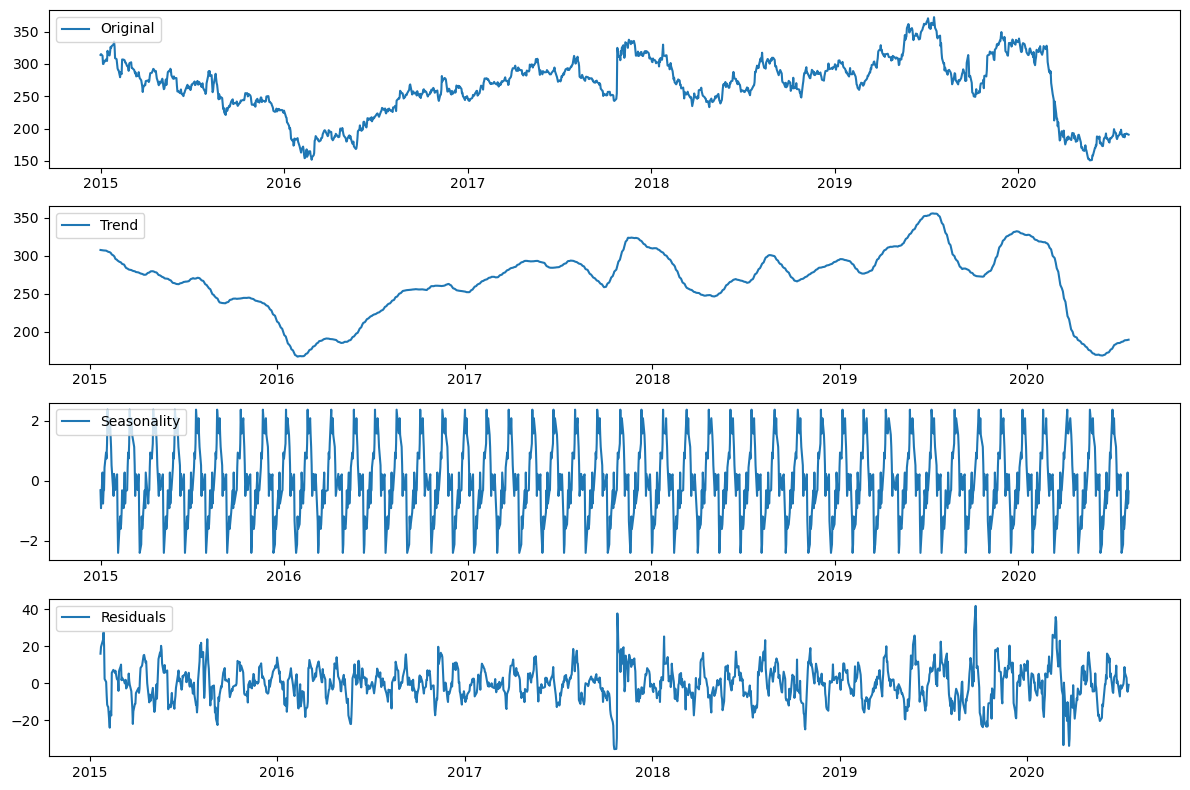

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sbi_df['Price'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Q. 3 Forecasting with ARIMA

### a. Parameter Selection using gridsearch

In [15]:
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
best_mse = np.inf
best_pdq = None

for params in pdq:
    try:
        model = ARIMA(sbi_df['Price'], order=params)
        results = model.fit()
        mse = mean_squared_error(sbi_df['Price'], results.fittedvalues)
        if mse < best_mse:
            best_mse = mse
            best_pdq = params
    except:
        continue

print("Best PDQ parameters:", best_pdq)

Best PDQ parameters: (2, 0, 1)


### b. Fit ARIMA model

In [16]:
model = ARIMA(sbi_df['Price'], order=best_pdq)
results = model.fit()

### c. Validate forecast

#### Split data into train and test sets

In [17]:
train_size = int(len(sbi_df) * 0.8)
train, test = sbi_df[:train_size], sbi_df[train_size:]

#### Fit model on training data

In [18]:
model = ARIMA(train['Price'], order=best_pdq)
results = model.fit()


#### Forecast

In [19]:
# Assuming `results` is the ARIMA model results and `test` is the test dataset

try:
    forecast_values = results.forecast(steps=len(test))
    if len(forecast_values) > 0:
        forecast = forecast_values[0]
    else:
        print("Forecast array is empty.")
except Exception as e:
    print("Error occurred while forecasting:", e)
    forecast = None

Error occurred while forecasting: 0


In [20]:
forecast = results.forecast(steps=len(test))

### d. Calculate the MSE and RMSE

In [21]:
mse = mean_squared_error(test['Price'], forecast)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 3482.8528716985484
Root Mean Squared Error: 59.01570021357493


### e. Visualize the forecast

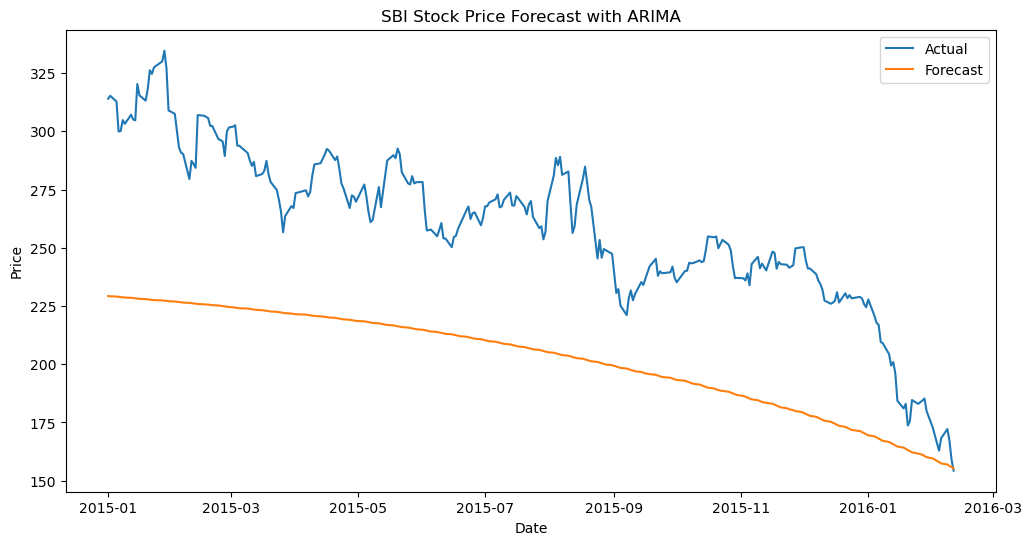

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Price'], label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title('SBI Stock Price Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()